In [1]:
import torch
import gpytorch
from gpytorch.kernels import RBFKernel
from ntwrk.bayesopt import Surrogate, BayesOpt

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
torch.random.manual_seed(88)

In [3]:
def true_func(x, noise=0.1):
    return 0.6 * torch.sin(3 * (x-1.)) + torch.sin(1.2 * x) + noise * torch.randn(x.shape)

In [4]:
test_x = torch.linspace(0, 5, 100)
true_y = true_func(test_x, noise=0.)

In [5]:
n_train = 30
train_x = torch.rand(n_train)
cutoff = int(n_train/2)
train_x[:cutoff] = train_x[:cutoff]*2
train_x[cutoff:] = train_x[cutoff:]*2 + 3
train_y = true_func(train_x, noise=0.1)

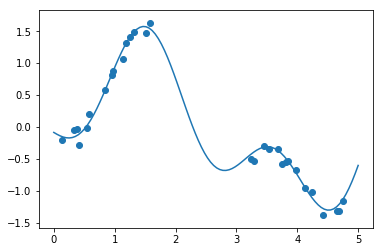

In [6]:
plt.plot(test_x, true_y.detach())
plt.scatter(train_x, train_y.detach())
plt.show()

## Some Prior Draws

In [7]:
lh = gpytorch.likelihoods.GaussianLikelihood()
model = Surrogate(test_x, true_y, lh, RBFKernel)

In [8]:
model.train()
lh.train();

n_samples = 4
samples = model(test_x).sample(sample_shape=torch.Size((n_samples,))).squeeze()


/home/vagrant/workspace/gpytorch/gpytorch/utils/cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


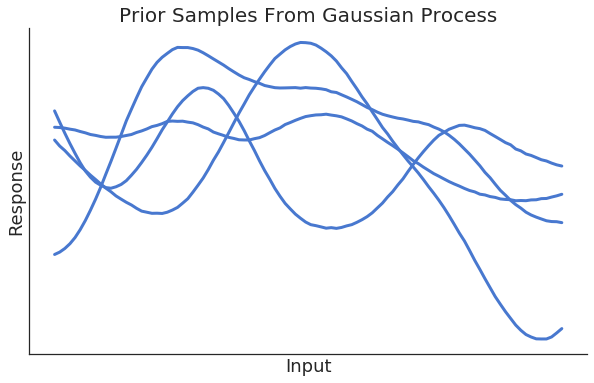

In [9]:
label_fs = 18
title_fs = 20
leg_fs = 16
lwd = 3.

plt.figure(figsize=(10, 6))
sns.set_style("white")
colors = sns.color_palette("muted")
for smp in range(n_samples):
    plt.plot(test_x, samples[smp, :].detach(), color=colors[0],
            linewidth=lwd)

# plt.plot(train_x, train_y.detach(), marker="o", linestyle="None",
#         label="Observations", color=colors[1], markersize=5)
# plt.plot(test_x, pred_mean.detach(), label="Predicted Mean", color=colors[0],
#         linewidth=lwd)
# plt.fill_between(test_x, lower.detach(), upper.detach(),
#                 alpha=0.2)

plt.title("Prior Samples From Gaussian Process", fontsize=title_fs)
plt.xlabel("Input", fontsize=label_fs)
plt.ylabel("Response", fontsize=label_fs)
plt.xticks([])
plt.yticks([])
sns.despine()
plt.legend( fontsize=leg_fs)
plt.show()

## Train and Get Posterior Samples

In [10]:
lh = gpytorch.likelihoods.GaussianLikelihood()
model = Surrogate(train_x, train_y, lh, RBFKernel)

In [11]:
model.train()
lh.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(lh, model)

for i in range(500):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    # print(loss.item())

In [12]:
model.eval()
lh.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [13]:
pred_dist = lh(model(test_x))
pred_mean = pred_dist.mean.detach()
lower, upper = pred_dist.confidence_region()

In [14]:
import seaborn as sns

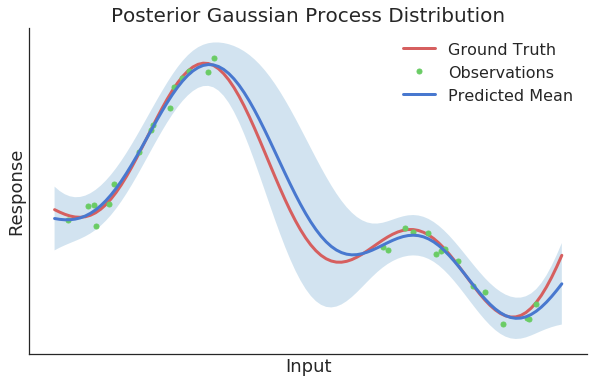

In [15]:
label_fs = 18
title_fs = 20
leg_fs = 16
lwd = 3.

plt.figure(figsize=(10, 6))
sns.set_style("white")
colors = sns.color_palette("muted")
plt.plot(test_x, true_y.detach(), label="Ground Truth", color=colors[2],
        linewidth=lwd)
plt.plot(train_x, train_y.detach(), marker="o", linestyle="None",
        label="Observations", color=colors[1], markersize=5)
plt.plot(test_x, pred_mean.detach(), label="Predicted Mean", color=colors[0],
        linewidth=lwd)
plt.fill_between(test_x, lower.detach(), upper.detach(),
                alpha=0.2)

plt.xlabel("Input", fontsize=label_fs)
plt.ylabel("Response", fontsize=label_fs)
plt.title("Posterior Gaussian Process Distribution",
         fontsize=title_fs)
plt.xticks([])
plt.yticks([])
sns.despine()
plt.legend(fontsize=leg_fs)
plt.show()

## Bayesian Optimization

In [16]:
train_x = torch.rand(5) * 5
train_y = true_func(train_x)

In [17]:
bayesopt = BayesOpt(train_x, train_y, normalize=False, normalize_y=False, max_x=5.)

In [18]:
# bayesopt.surrogate.train()
# bayesopt.surrogate_lh.train()

# optimizer = torch.optim.Adam(bayesopt.surrogate.parameters(), lr=0.01)
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(bayesopt.surrogate_lh,
#                                                bayesopt.surrogate)

# for i in range(200):
#     # Zero gradients from previous iteration
#     optimizer.zero_grad()
#     # Output from model
#     output = bayesopt.surrogate(bayesopt.train_x)
#     # Calc loss and backprop gradients
#     loss = -mll(output, bayesopt.train_y)
#     loss.backward()
#     optimizer.step()
#     print(loss.item())

In [19]:
bayesopt.train_surrogate(200)

In [20]:
bayesopt.surrogate

Surrogate(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (raw_lengthscale_constraint): Positive()
      (distance_module): Distance()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [21]:
next_query = bayesopt.acquire()

In [22]:
bayesopt.surrogate.eval();
bayesopt.surrogate_lh.eval();

pred_dist = bayesopt.surrogate_lh(bayesopt.surrogate(test_x))
pred_mean = pred_dist.mean.detach()
lower, upper = pred_dist.confidence_region()

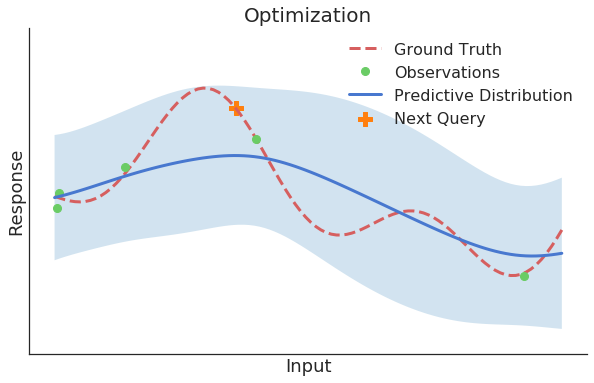

In [23]:
label_fs = 18
title_fs = 20
leg_fs = 16
lwd = 3.

plt.figure(figsize=(10, 6))
sns.set_style("white")
colors = sns.color_palette("muted")
plt.plot(test_x, true_y.detach(), label="Ground Truth", color=colors[2],
        linewidth=lwd, linestyle="--")
plt.plot(train_x, train_y.detach(), marker="o", linestyle="None",
        label="Observations", color=colors[1], markersize=8)
plt.plot(test_x, pred_mean.detach(), label="Predictive Distribution", color=colors[0],
        linewidth=lwd)
plt.fill_between(test_x, lower.detach(), upper.detach(),
                alpha=0.2)

plt.scatter(next_query, true_func(next_query, 0.).detach(), marker="P", s=200,
           label="Next Query")

plt.xlabel("Input", fontsize=label_fs)
plt.ylabel("Response", fontsize=label_fs)
plt.title("Optimization",
         fontsize=title_fs)
plt.xticks([])
plt.yticks([])
plt.ylim(-2.5, 2.5)
sns.despine()
plt.legend(fontsize=leg_fs)
plt.show()

In [24]:
bayesopt.update_obs(next_query.unsqueeze(0), true_func(next_query).unsqueeze(0))

In [25]:
bayesopt.train_surrogate(200);

In [26]:
next_query = bayesopt.acquire()

In [27]:
bayesopt.surrogate.eval();
bayesopt.surrogate_lh.eval();

pred_dist = bayesopt.surrogate_lh(bayesopt.surrogate(test_x))
pred_mean = pred_dist.mean.detach()
lower, upper = pred_dist.confidence_region()

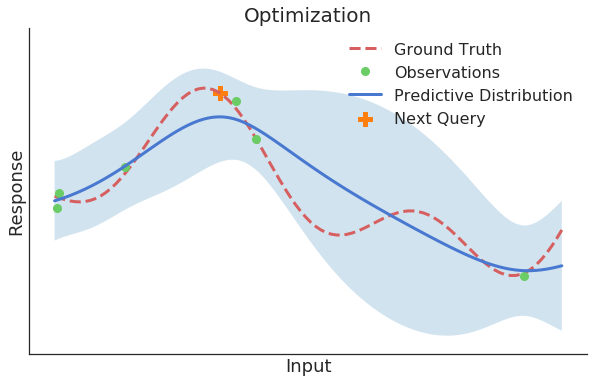

In [28]:
label_fs = 18
title_fs = 20
leg_fs = 16
lwd = 3.

plt.figure(figsize=(10, 6))
sns.set_style("white")
colors = sns.color_palette("muted")
plt.plot(test_x, true_y.detach(), label="Ground Truth", color=colors[2],
        linewidth=lwd, linestyle="--")
plt.plot(bayesopt.train_x, bayesopt.train_y.detach(), marker="o", linestyle="None",
        label="Observations", color=colors[1], markersize=8)
plt.plot(test_x, pred_mean.detach(), label="Predictive Distribution", color=colors[0],
        linewidth=lwd)
plt.fill_between(test_x, lower.detach(), upper.detach(),
                alpha=0.2)

plt.scatter(next_query, true_func(next_query, 0.).detach(), marker="P", s=200,
           label="Next Query")

plt.xlabel("Input", fontsize=label_fs)
plt.ylabel("Response", fontsize=label_fs)
plt.title("Optimization",
         fontsize=title_fs)
plt.xticks([])
plt.yticks([])
plt.ylim(-2.5, 2.5)
sns.despine()
plt.legend(fontsize=leg_fs)
plt.show()

In [29]:
bayesopt.update_obs(next_query.unsqueeze(0), true_func(next_query).unsqueeze(0))

In [30]:
bayesopt.train_surrogate(200);

In [31]:
next_query = bayesopt.acquire()

In [32]:
bayesopt.surrogate.eval();
bayesopt.surrogate_lh.eval();

pred_dist = bayesopt.surrogate_lh(bayesopt.surrogate(test_x))
pred_mean = pred_dist.mean.detach()
lower, upper = pred_dist.confidence_region()

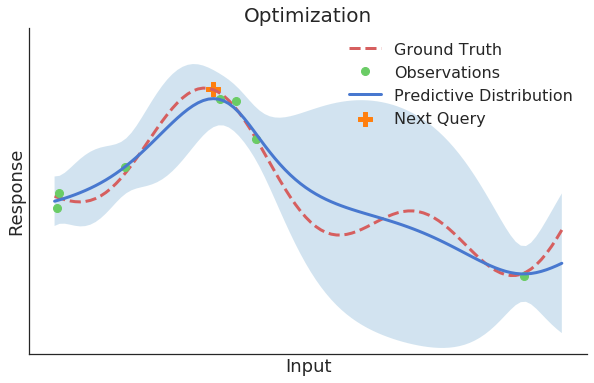

In [33]:
label_fs = 18
title_fs = 20
leg_fs = 16
lwd = 3.

plt.figure(figsize=(10, 6))
sns.set_style("white")
colors = sns.color_palette("muted")
plt.plot(test_x, true_y.detach(), label="Ground Truth", color=colors[2],
        linewidth=lwd, linestyle="--")
plt.plot(bayesopt.train_x, bayesopt.train_y.detach(), marker="o", linestyle="None",
        label="Observations", color=colors[1], markersize=8)
plt.plot(test_x, pred_mean.detach(), label="Predictive Distribution", color=colors[0],
        linewidth=lwd)
plt.fill_between(test_x, lower.detach(), upper.detach(),
                alpha=0.2)

plt.scatter(next_query, true_func(next_query, 0.).detach(), marker="P", s=200,
           label="Next Query")

plt.xlabel("Input", fontsize=label_fs)
plt.ylabel("Response", fontsize=label_fs)
plt.title("Optimization",
         fontsize=title_fs)
plt.xticks([])
plt.yticks([])
plt.ylim(-2.5, 2.5)
sns.despine()
plt.legend(fontsize=leg_fs)
plt.show()

## Network Plots

In [34]:
import sys
sys.path.append("../ntwrk/gym/")
import network_sim
import gym

In [35]:
env = gym.make("PccNs-v0")
env.reset()

History length: 10
Features: ['sent latency inflation', 'latency ratio', 'send ratio']
Getting min obs for ['sent latency inflation', 'latency ratio', 'send ratio']
Reward: 0.00, Ewma Reward: 0.00


/home/vagrant/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.])

In [36]:
send_rates = torch.arange(1, 1000, 25)

In [37]:
n_trial = 100
rwrds = torch.zeros(send_rates.numel(), n_trial)

for ind, sr in enumerate(send_rates):
    for tt in range(n_trial):
        rwrds[ind, tt] = env.step(sr.unsqueeze(0))[1]
        env.reset()

Reward: 1.00, Ewma Reward: 0.01
Reward: 1.63, Ewma Reward: 0.03
Reward: 0.12, Ewma Reward: 0.03
Reward: 1.04, Ewma Reward: 0.04
Reward: 0.08, Ewma Reward: 0.04
Reward: 0.67, Ewma Reward: 0.04
Reward: 1.94, Ewma Reward: 0.06
Reward: 0.07, Ewma Reward: 0.06
Reward: -0.13, Ewma Reward: 0.06
Reward: 1.18, Ewma Reward: 0.07
Reward: 0.22, Ewma Reward: 0.07
Reward: 0.30, Ewma Reward: 0.08
Reward: 0.87, Ewma Reward: 0.08
Reward: 1.09, Ewma Reward: 0.09
Reward: 0.78, Ewma Reward: 0.10
Reward: 0.55, Ewma Reward: 0.11
Reward: 1.00, Ewma Reward: 0.11
Reward: 0.45, Ewma Reward: 0.12
Reward: 1.64, Ewma Reward: 0.13
Reward: 0.16, Ewma Reward: 0.13
Reward: 0.61, Ewma Reward: 0.14
Reward: 0.44, Ewma Reward: 0.14
Reward: 1.74, Ewma Reward: 0.16
Reward: -0.30, Ewma Reward: 0.15
Reward: 0.54, Ewma Reward: 0.16
Reward: 2.20, Ewma Reward: 0.18
Reward: 1.48, Ewma Reward: 0.19
Reward: 0.38, Ewma Reward: 0.19
Reward: 1.28, Ewma Reward: 0.20
Reward: -0.07, Ewma Reward: 0.20
Reward: 0.19, Ewma Reward: 0.20
Rewar

Reward: 0.86, Ewma Reward: 0.57
Reward: 0.88, Ewma Reward: 0.57
Reward: 0.29, Ewma Reward: 0.57
Reward: 0.44, Ewma Reward: 0.57
Reward: 1.05, Ewma Reward: 0.57
Reward: 0.42, Ewma Reward: 0.57
Reward: 0.44, Ewma Reward: 0.57
Reward: 0.60, Ewma Reward: 0.57
Reward: -0.62, Ewma Reward: 0.56
Reward: 0.30, Ewma Reward: 0.55
Reward: -0.23, Ewma Reward: 0.55
Reward: 0.97, Ewma Reward: 0.55
Reward: 0.78, Ewma Reward: 0.55
Reward: 0.29, Ewma Reward: 0.55
Reward: 0.38, Ewma Reward: 0.55
Reward: 1.06, Ewma Reward: 0.55
Reward: 0.56, Ewma Reward: 0.55
Reward: 0.59, Ewma Reward: 0.55
Reward: -0.44, Ewma Reward: 0.54
Reward: 1.10, Ewma Reward: 0.55
Reward: 1.08, Ewma Reward: 0.56
Reward: -0.04, Ewma Reward: 0.55
Reward: 0.23, Ewma Reward: 0.55
Reward: -0.57, Ewma Reward: 0.54
Reward: 0.83, Ewma Reward: 0.54
Reward: 0.03, Ewma Reward: 0.53
Reward: -0.23, Ewma Reward: 0.53
Reward: 1.24, Ewma Reward: 0.53
Reward: 0.67, Ewma Reward: 0.53
Reward: 0.59, Ewma Reward: 0.53
Reward: 1.78, Ewma Reward: 0.55
Re

Reward: 0.16, Ewma Reward: 0.73
Reward: 0.87, Ewma Reward: 0.73
Reward: 1.09, Ewma Reward: 0.73
Reward: 0.31, Ewma Reward: 0.73
Reward: 0.54, Ewma Reward: 0.73
Reward: 1.21, Ewma Reward: 0.73
Reward: 0.28, Ewma Reward: 0.73
Reward: -0.02, Ewma Reward: 0.72
Reward: 1.39, Ewma Reward: 0.72
Reward: 1.04, Ewma Reward: 0.73
Reward: 0.15, Ewma Reward: 0.72
Reward: 0.61, Ewma Reward: 0.72
Reward: -0.10, Ewma Reward: 0.71
Reward: 1.08, Ewma Reward: 0.72
Reward: 0.79, Ewma Reward: 0.72
Reward: 0.05, Ewma Reward: 0.71
Reward: 0.09, Ewma Reward: 0.70
Reward: 1.10, Ewma Reward: 0.71
Reward: 0.74, Ewma Reward: 0.71
Reward: 0.34, Ewma Reward: 0.70
Reward: 0.64, Ewma Reward: 0.70
Reward: 0.27, Ewma Reward: 0.70
Reward: 0.72, Ewma Reward: 0.70
Reward: 0.27, Ewma Reward: 0.70
Reward: 0.95, Ewma Reward: 0.70
Reward: 0.11, Ewma Reward: 0.69
Reward: 0.07, Ewma Reward: 0.69
Reward: 1.13, Ewma Reward: 0.69
Reward: 0.50, Ewma Reward: 0.69
Reward: 0.79, Ewma Reward: 0.69
Reward: -0.04, Ewma Reward: 0.68
Rewar

Reward: 0.91, Ewma Reward: 0.91
Reward: 0.78, Ewma Reward: 0.91
Reward: -0.50, Ewma Reward: 0.89
Reward: 0.94, Ewma Reward: 0.89
Reward: 0.46, Ewma Reward: 0.89
Reward: 2.57, Ewma Reward: 0.90
Reward: 0.56, Ewma Reward: 0.90
Reward: 0.89, Ewma Reward: 0.90
Reward: 0.96, Ewma Reward: 0.90
Reward: 0.59, Ewma Reward: 0.90
Reward: 1.45, Ewma Reward: 0.90
Reward: 1.18, Ewma Reward: 0.91
Reward: 0.27, Ewma Reward: 0.90
Reward: 1.33, Ewma Reward: 0.91
Reward: 0.65, Ewma Reward: 0.90
Reward: 0.85, Ewma Reward: 0.90
Reward: 1.35, Ewma Reward: 0.91
Reward: 1.52, Ewma Reward: 0.91
Reward: 0.66, Ewma Reward: 0.91
Reward: 0.51, Ewma Reward: 0.91
Reward: 1.34, Ewma Reward: 0.91
Reward: 0.34, Ewma Reward: 0.90
Reward: 1.04, Ewma Reward: 0.91
Reward: 1.05, Ewma Reward: 0.91
Reward: 1.35, Ewma Reward: 0.91
Reward: 1.45, Ewma Reward: 0.92
Reward: 1.12, Ewma Reward: 0.92
Reward: 2.27, Ewma Reward: 0.93
Reward: 0.70, Ewma Reward: 0.93
Reward: 1.20, Ewma Reward: 0.93
Reward: 0.93, Ewma Reward: 0.93
Reward:

Reward: 0.36, Ewma Reward: 0.92
Reward: 0.93, Ewma Reward: 0.92
Reward: 1.01, Ewma Reward: 0.92
Reward: 1.80, Ewma Reward: 0.93
Reward: 0.18, Ewma Reward: 0.93
Reward: 1.31, Ewma Reward: 0.93
Reward: 1.08, Ewma Reward: 0.93
Reward: 0.69, Ewma Reward: 0.93
Reward: 1.22, Ewma Reward: 0.93
Reward: 0.54, Ewma Reward: 0.93
Reward: 1.27, Ewma Reward: 0.93
Reward: 0.32, Ewma Reward: 0.92
Reward: 1.97, Ewma Reward: 0.94
Reward: 0.91, Ewma Reward: 0.94
Reward: 2.11, Ewma Reward: 0.95
Reward: 1.01, Ewma Reward: 0.95
Reward: 1.12, Ewma Reward: 0.95
Reward: 2.62, Ewma Reward: 0.97
Reward: 0.05, Ewma Reward: 0.96
Reward: 0.10, Ewma Reward: 0.95
Reward: 1.48, Ewma Reward: 0.95
Reward: 0.17, Ewma Reward: 0.95
Reward: 0.98, Ewma Reward: 0.95
Reward: 1.34, Ewma Reward: 0.95
Reward: 0.14, Ewma Reward: 0.94
Reward: 1.53, Ewma Reward: 0.95
Reward: 1.64, Ewma Reward: 0.95
Reward: 0.81, Ewma Reward: 0.95
Reward: 2.12, Ewma Reward: 0.97
Reward: 1.09, Ewma Reward: 0.97
Reward: 0.71, Ewma Reward: 0.96
Reward: 

Reward: 0.36, Ewma Reward: 0.85
Reward: 1.20, Ewma Reward: 0.85
Reward: 0.69, Ewma Reward: 0.85
Reward: 0.44, Ewma Reward: 0.85
Reward: 0.23, Ewma Reward: 0.84
Reward: 1.72, Ewma Reward: 0.85
Reward: 0.89, Ewma Reward: 0.85
Reward: 0.39, Ewma Reward: 0.85
Reward: 0.53, Ewma Reward: 0.84
Reward: 0.85, Ewma Reward: 0.84
Reward: 1.28, Ewma Reward: 0.85
Reward: 0.62, Ewma Reward: 0.84
Reward: 1.93, Ewma Reward: 0.86
Reward: 0.12, Ewma Reward: 0.85
Reward: 2.64, Ewma Reward: 0.87
Reward: 1.55, Ewma Reward: 0.87
Reward: 0.04, Ewma Reward: 0.86
Reward: 1.64, Ewma Reward: 0.87
Reward: 0.16, Ewma Reward: 0.86
Reward: 0.16, Ewma Reward: 0.86
Reward: 1.20, Ewma Reward: 0.86
Reward: 1.31, Ewma Reward: 0.87
Reward: 1.37, Ewma Reward: 0.87
Reward: 1.43, Ewma Reward: 0.88
Reward: -0.38, Ewma Reward: 0.86
Reward: 0.47, Ewma Reward: 0.86
Reward: 0.37, Ewma Reward: 0.86
Reward: 0.61, Ewma Reward: 0.85
Reward: 2.39, Ewma Reward: 0.87
Reward: 1.26, Ewma Reward: 0.87
Reward: 1.46, Ewma Reward: 0.88
Reward:

Reward: -0.36, Ewma Reward: 0.90
Reward: -0.55, Ewma Reward: 0.89
Reward: 1.54, Ewma Reward: 0.89
Reward: 0.93, Ewma Reward: 0.90
Reward: 0.99, Ewma Reward: 0.90
Reward: -0.65, Ewma Reward: 0.88
Reward: 1.20, Ewma Reward: 0.88
Reward: 0.83, Ewma Reward: 0.88
Reward: 0.59, Ewma Reward: 0.88
Reward: 0.92, Ewma Reward: 0.88
Reward: 0.28, Ewma Reward: 0.87
Reward: 1.16, Ewma Reward: 0.88
Reward: 0.59, Ewma Reward: 0.87
Reward: 1.36, Ewma Reward: 0.88
Reward: 1.65, Ewma Reward: 0.89
Reward: 1.98, Ewma Reward: 0.90
Reward: 0.93, Ewma Reward: 0.90
Reward: -0.19, Ewma Reward: 0.89
Reward: -0.72, Ewma Reward: 0.87
Reward: 0.94, Ewma Reward: 0.87
Reward: 0.09, Ewma Reward: 0.86
Reward: 0.39, Ewma Reward: 0.86
Reward: 0.62, Ewma Reward: 0.86
Reward: 1.02, Ewma Reward: 0.86
Reward: 0.98, Ewma Reward: 0.86
Reward: 0.20, Ewma Reward: 0.85
Reward: 1.98, Ewma Reward: 0.86
Reward: -0.34, Ewma Reward: 0.85
Reward: 2.24, Ewma Reward: 0.87
Reward: 0.50, Ewma Reward: 0.86
Reward: 1.34, Ewma Reward: 0.87
Re

Reward: -0.16, Ewma Reward: 0.71
Reward: 0.27, Ewma Reward: 0.71
Reward: 1.36, Ewma Reward: 0.71
Reward: 0.45, Ewma Reward: 0.71
Reward: 0.95, Ewma Reward: 0.71
Reward: -0.05, Ewma Reward: 0.71
Reward: 0.67, Ewma Reward: 0.71
Reward: 1.59, Ewma Reward: 0.72
Reward: 0.66, Ewma Reward: 0.71
Reward: -0.61, Ewma Reward: 0.70
Reward: 1.57, Ewma Reward: 0.71
Reward: 1.32, Ewma Reward: 0.72
Reward: 1.66, Ewma Reward: 0.73
Reward: 1.03, Ewma Reward: 0.73
Reward: 0.37, Ewma Reward: 0.73
Reward: 1.37, Ewma Reward: 0.73
Reward: 2.36, Ewma Reward: 0.75
Reward: 1.42, Ewma Reward: 0.75
Reward: 1.33, Ewma Reward: 0.76
Reward: 0.55, Ewma Reward: 0.76
Reward: 0.60, Ewma Reward: 0.76
Reward: 1.07, Ewma Reward: 0.76
Reward: 0.99, Ewma Reward: 0.76
Reward: 1.26, Ewma Reward: 0.77
Reward: 1.21, Ewma Reward: 0.77
Reward: -1.02, Ewma Reward: 0.75
Reward: 0.18, Ewma Reward: 0.75
Reward: 0.25, Ewma Reward: 0.74
Reward: 0.88, Ewma Reward: 0.74
Reward: 0.65, Ewma Reward: 0.74
Reward: 0.32, Ewma Reward: 0.74
Rewa

Reward: 0.55, Ewma Reward: 0.75
Reward: 1.22, Ewma Reward: 0.76
Reward: 0.82, Ewma Reward: 0.76
Reward: -1.48, Ewma Reward: 0.74
Reward: 0.78, Ewma Reward: 0.74
Reward: -0.45, Ewma Reward: 0.72
Reward: 2.38, Ewma Reward: 0.74
Reward: 1.04, Ewma Reward: 0.74
Reward: 1.27, Ewma Reward: 0.75
Reward: 1.08, Ewma Reward: 0.75
Reward: 0.31, Ewma Reward: 0.75
Reward: -0.57, Ewma Reward: 0.73
Reward: 0.59, Ewma Reward: 0.73
Reward: -0.04, Ewma Reward: 0.73
Reward: 0.93, Ewma Reward: 0.73
Reward: 0.32, Ewma Reward: 0.72
Reward: 0.45, Ewma Reward: 0.72
Reward: 0.83, Ewma Reward: 0.72
Reward: 0.34, Ewma Reward: 0.72
Reward: -0.35, Ewma Reward: 0.71
Reward: 2.32, Ewma Reward: 0.72
Reward: 0.81, Ewma Reward: 0.72
Reward: 1.05, Ewma Reward: 0.73
Reward: 1.06, Ewma Reward: 0.73
Reward: 1.62, Ewma Reward: 0.74
Reward: 0.57, Ewma Reward: 0.74
Reward: 0.98, Ewma Reward: 0.74
Reward: 0.25, Ewma Reward: 0.74
Reward: 1.52, Ewma Reward: 0.74
Reward: 0.48, Ewma Reward: 0.74
Reward: -0.01, Ewma Reward: 0.73
Re

Reward: -0.99, Ewma Reward: 0.66
Reward: 0.28, Ewma Reward: 0.65
Reward: 0.38, Ewma Reward: 0.65
Reward: 1.97, Ewma Reward: 0.66
Reward: 1.30, Ewma Reward: 0.67
Reward: 1.99, Ewma Reward: 0.68
Reward: 0.69, Ewma Reward: 0.68
Reward: 1.31, Ewma Reward: 0.69
Reward: 0.36, Ewma Reward: 0.69
Reward: 1.32, Ewma Reward: 0.69
Reward: 1.09, Ewma Reward: 0.70
Reward: 0.72, Ewma Reward: 0.70
Reward: 0.83, Ewma Reward: 0.70
Reward: 1.23, Ewma Reward: 0.70
Reward: 0.19, Ewma Reward: 0.70
Reward: -1.06, Ewma Reward: 0.68
Reward: -0.09, Ewma Reward: 0.67
Reward: 1.04, Ewma Reward: 0.68
Reward: -0.71, Ewma Reward: 0.66
Reward: 0.32, Ewma Reward: 0.66
Reward: 0.46, Ewma Reward: 0.66
Reward: -0.11, Ewma Reward: 0.65
Reward: 0.32, Ewma Reward: 0.65
Reward: -0.70, Ewma Reward: 0.63
Reward: 0.72, Ewma Reward: 0.63
Reward: 0.79, Ewma Reward: 0.63
Reward: -0.78, Ewma Reward: 0.62
Reward: 0.69, Ewma Reward: 0.62
Reward: 0.86, Ewma Reward: 0.62
Reward: 0.55, Ewma Reward: 0.62
Reward: -0.21, Ewma Reward: 0.61


Reward: -0.73, Ewma Reward: 0.61
Reward: 1.40, Ewma Reward: 0.62
Reward: -1.15, Ewma Reward: 0.60
Reward: 0.59, Ewma Reward: 0.60
Reward: -1.32, Ewma Reward: 0.58
Reward: -0.00, Ewma Reward: 0.57
Reward: 0.75, Ewma Reward: 0.58
Reward: -0.22, Ewma Reward: 0.57
Reward: 0.62, Ewma Reward: 0.57
Reward: 2.05, Ewma Reward: 0.58
Reward: 1.24, Ewma Reward: 0.59
Reward: 1.44, Ewma Reward: 0.60
Reward: 1.79, Ewma Reward: 0.61
Reward: 1.52, Ewma Reward: 0.62
Reward: 1.13, Ewma Reward: 0.62
Reward: 1.04, Ewma Reward: 0.63
Reward: 0.27, Ewma Reward: 0.63
Reward: 0.73, Ewma Reward: 0.63
Reward: 1.79, Ewma Reward: 0.64
Reward: 1.23, Ewma Reward: 0.64
Reward: 1.61, Ewma Reward: 0.65
Reward: -0.03, Ewma Reward: 0.65
Reward: 1.76, Ewma Reward: 0.66
Reward: 0.46, Ewma Reward: 0.66
Reward: 0.07, Ewma Reward: 0.65
Reward: 2.13, Ewma Reward: 0.67
Reward: -0.17, Ewma Reward: 0.66
Reward: -0.80, Ewma Reward: 0.64
Reward: 1.14, Ewma Reward: 0.65
Reward: 2.41, Ewma Reward: 0.66
Reward: -1.12, Ewma Reward: 0.65

In [38]:
mean_rwrd = rwrds.mean(1).unsqueeze(-1)
std_rwrd = rwrds.std(1).unsqueeze(-1)

In [39]:
mean_rwrd.shape

torch.Size([40, 1])

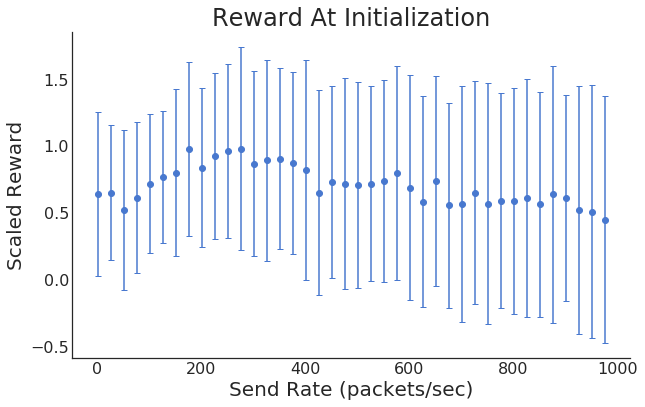

In [40]:
sns.set_style("white")
sns.set_palette("muted")

label_fs = 20
title_fs = 24
tick_fs = 16

plt.figure(figsize=(10, 6))
plt.errorbar(x=send_rates, y=mean_rwrd, yerr=std_rwrd,
            linestyle="None", marker='o',
            capsize=3)

plt.tick_params(labelsize=tick_fs)
plt.title("Reward At Initialization", fontsize=title_fs)
plt.xlabel("Send Rate (packets/sec)", fontsize=label_fs)
plt.ylabel("Scaled Reward", fontsize=label_fs)
sns.despine()
plt.show()


In [41]:
# init_send_rate = torch.tensor(850).unsqueeze(0)
# n_init_send = 20
# n_trial = 100

# rwrds = torch.zeros(send_rates.numel(), n_trial)
# for ind, sr in enumerate(send_rates):
#     for tt in range(n_trial):
#         for snd in range(n_init_send):
#             env.step(init_send_rate)

#         rwrds[ind, tt] = env.step(sr.unsqueeze(0))[1]
#         env.reset()
    

In [42]:
# mean_rwrd = rwrds.mean(1).unsqueeze(-1)
# std_rwrd = rwrds.std(1).unsqueeze(-1)

In [43]:
# sns.set_style("white")
# sns.set_palette("muted")

# label_fs = 20
# title_fs = 24
# tick_fs = 16

# plt.figure(figsize=(10, 6))
# plt.errorbar(x=send_rates, y=mean_rwrd, yerr=std_rwrd,
#             linestyle="None", marker='o',
#             capsize=3)

# plt.tick_params(labelsize=tick_fs)
# plt.title("Reward After 20 Time Steps", fontsize=title_fs)
# plt.xlabel("Send Rate (packets/sec)", fontsize=label_fs)
# plt.ylabel("Scaled Reward", fontsize=label_fs)
# sns.despine()
# plt.show()


## Bayesian Optimization for Network

In [44]:
env = gym.make("PccNs-v0")
env.reset()
env.senders[0].rate = env.senders[0].starting_rate

rate = torch.tensor(env.senders[0].rate).unsqueeze(0)
rwrd = torch.tensor(env.step(rate)[1]).unsqueeze(0)

History length: 10
Features: ['sent latency inflation', 'latency ratio', 'send ratio']
Getting min obs for ['sent latency inflation', 'latency ratio', 'send ratio']
Reward: 0.00, Ewma Reward: 0.00


/home/vagrant/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [45]:
max_x = 1000.

bayes_opt = BayesOpt(rate, rwrd, normalize=True, normalize_y=False, max_x=max_x,
                    max_jump=400)
bayes_opt.surrogate_lh.noise.data = torch.tensor([-1.])

In [46]:
rnds = 10
max_obs = 3
test_points = torch.arange(1, 1000).float().div(max_x)

rate_history = torch.zeros(rnds, max_obs + 1)
rwrd_history = torch.zeros(rnds, max_obs + 1)
pred_means = torch.zeros(rnds, test_points.numel())
pred_lower = torch.zeros(rnds, test_points.numel())
pred_upper = torch.zeros(rnds, test_points.numel())

In [47]:


for ii in range(rnds):
    bayes_opt.train_surrogate(iters=200, overwrite=True)
    next_rate = bayes_opt.acquire(explore=0.5).unsqueeze(0)
#     next_rate = torch.rand(1)

    rwrd = torch.tensor(env.step(next_rate.mul(bayes_opt.max_x))[1]).unsqueeze(0)
    print(next_rate, rwrd)
    rate_history[ii, :bayes_opt.train_x.numel()] = bayes_opt.train_x.clone()
    rwrd_history[ii, :bayes_opt.train_y.numel()] = bayes_opt.train_y.clone()

    bayes_opt.update_obs(next_rate, rwrd, max_obs=max_obs)
    print("train x = ", bayes_opt.train_x)
    bayes_opt.surrogate_lh.eval()
    bayes_opt.surrogate.eval()
    test_dist = bayes_opt.surrogate_lh(bayes_opt.surrogate(test_points))
    
    pred_means[ii, :] = test_dist.mean.detach()
    pred_lower[ii, :], pred_upper[ii, :] = test_dist.confidence_region()
    
    rate_history[ii, -1] = bayes_opt.train_x[-1].clone()
    rwrd_history[ii, -1] = bayes_opt.train_y[-1].clone()
    

#     plt.plot(bayes_opt.train_x[:-1], bayes_opt.train_y[:-1], marker='.', linestyle="None")
#     plt.plot(bayes_opt.train_x[-1], bayes_opt.train_y[-1], marker='*', linestyle="None")
#     plt.plot(test_points, test_dist.mean.detach())
#     plt.show()

hitting boundary
tensor([859.2964]) tensor([0.4972])
train x =  tensor([0.0965, 0.8593])
hitting boundary
tensor([904.5226]) tensor([0.4972])
train x =  tensor([0.0965, 0.8593, 0.9045])
hitting boundary
tensor([839.1960]) tensor([0.4510])
train x =  tensor([0.8593, 0.9045, 0.8392])
hitting boundary
tensor([0.]) tensor([0.1655])
train x =  tensor([0.9045, 0.8392, 0.0000])
hitting boundary
tensor([989.9497]) tensor([-1.5874])
train x =  tensor([0.8392, 0.0000, 0.9899])
tensor([824.1206]) tensor([-1.4276])
train x =  tensor([0.0000, 0.9899, 0.8241])
hitting boundary
tensor([0.]) tensor([-1.5322])
train x =  tensor([0.9899, 0.8241, 0.0000])
hitting boundary
tensor([0.]) tensor([-1.6059])
train x =  tensor([0.8241, 0.0000, 0.0000])
hitting boundary
tensor([889.4472]) tensor([-0.7891])
train x =  tensor([0.0000, 0.0000, 0.8894])
hitting boundary
tensor([844.2211]) tensor([0.3598])
train x =  tensor([0.0000, 0.8894, 0.8442])


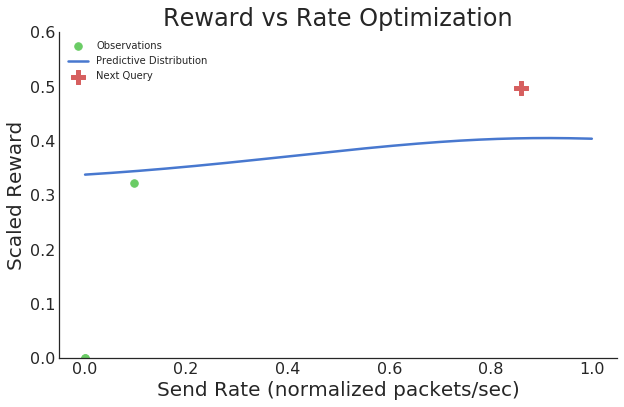

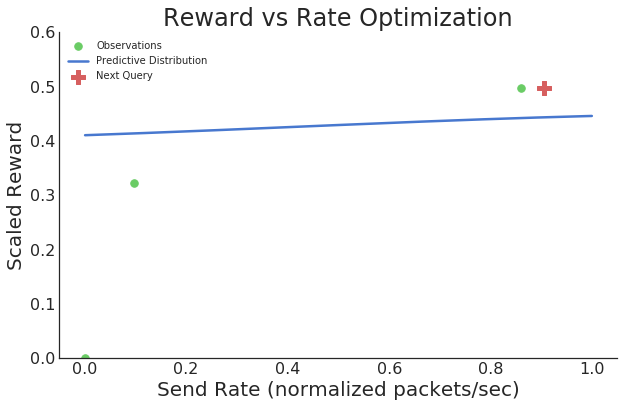

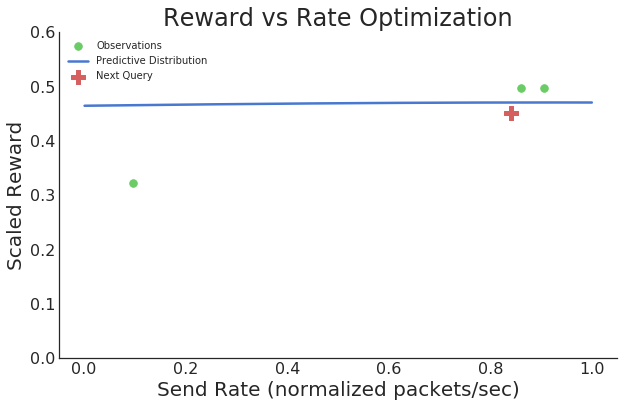

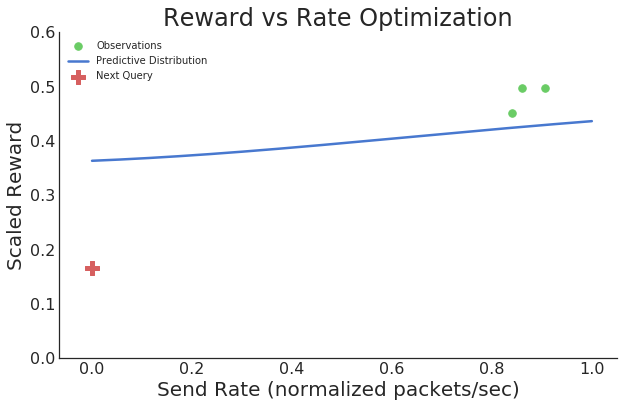

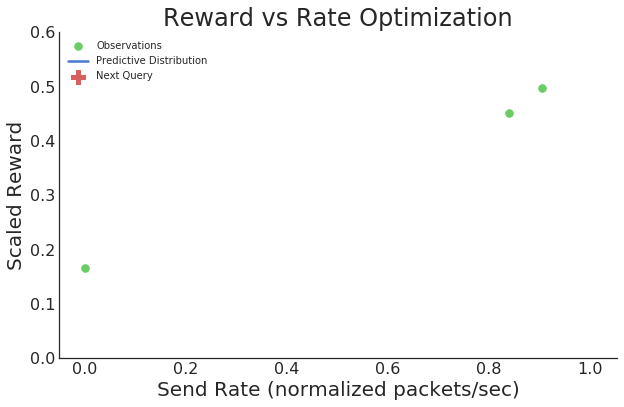

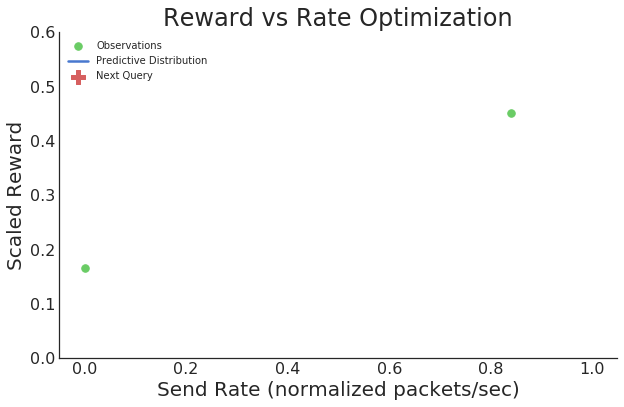

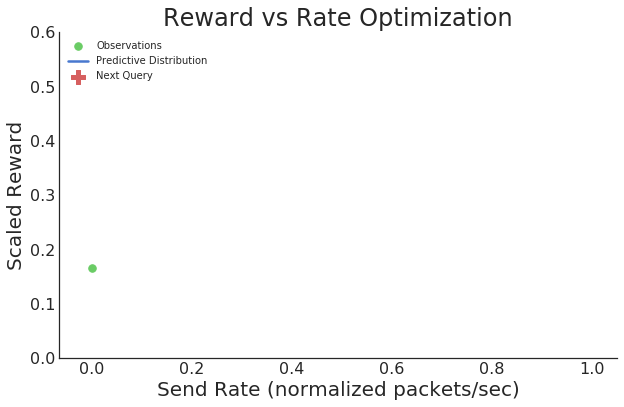

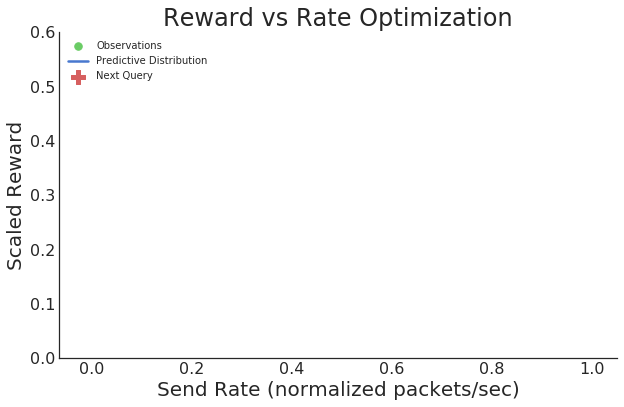

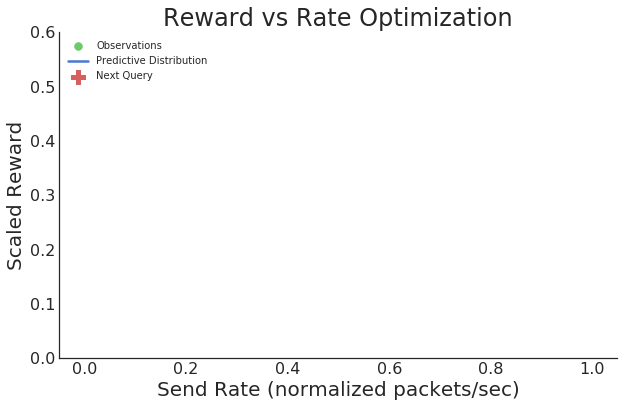

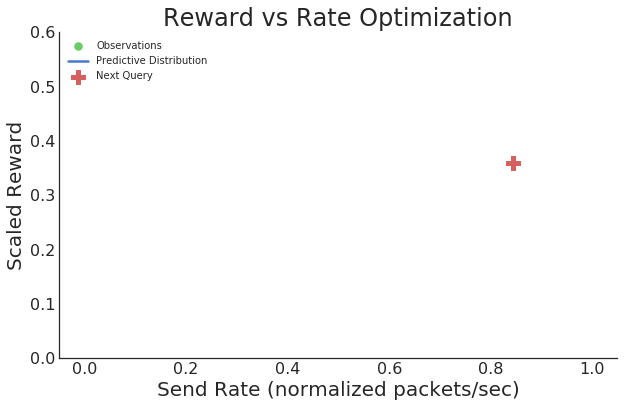

In [51]:
# sns.set_style("white")
# colors = sns.color_palette("muted")

label_fs = 20
title_fs = 24
tick_fs = 16
leg_fs = 18
marksize=15
lwd = 2.5


for rnd in range(rnds):
    plt.figure(figsize=(10, 6))

    plt.plot(rate_history[rnd, :-1], rwrd_history[rnd, :-1], marker=".", linestyle="None",
            label="Observations", color=colors[1], markersize=marksize)

    plt.plot(test_points, pred_means[rnd, :], label="Predictive Distribution",
            linewidth=lwd)
    plt.scatter(rate_history[rnd, -1], rwrd_history[rnd, -1], marker="P",s=200,
        label="Next Query", linestyle="None", color=colors[2])

    plt.tick_params(labelsize=tick_fs)
    plt.title("Reward vs Rate Optimization", fontsize=title_fs)
    plt.xlabel("Send Rate (normalized packets/sec)", fontsize=label_fs)
    plt.ylabel("Scaled Reward", fontsize=label_fs)
    plt.legend(loc='upper left')
    sns.despine()
    plt.ylim(0, 0.6)
    plt.show()
    